## Assignment 2: $k$ Nearest Neighbor

### Do any four: I did Q1, 2, 3, and 6

**Q1.** Please answer the following questions.
1. What is the difference between regression and classification?
2. What is a confusion table/matrix? What does it help us understand about a model's performance? 
3. What is Accuracy? Why might it not be entirely sufficient to evaluate a classifer's predictive performance?
4. What does the root mean squared error quantify about a particular model?
5. What are overfitting and underfitting? 
6. Why does splitting the data into training and testing sets, and choosing $k$ by evaluating accuracy or RMSE on the test set, improve model performance?
7. With classification, we can report a class label as a prediction or a probability distribution over class labels. Please explain the strengths and weaknesses of each approach.

## Question 1: Part 1

- Classification predicts a categorical label (like Disease vs. No Disease). You take a majority vote among the k neighbors. 
- Regression predicts a continuous number (like House Price or Temperature). You take the mean of the neighbors.

## Question 1: Part 2

- A confusion matrix evaluates fit and understands whether we're making good/bad predictions in machine learning. It cross-tabulates the true labels with the predicted ones, and sees if they align or not. 
- It helps us understand if it worked ("Did it work?")

## Question 1: Part 3

- Accuracy is the proportion of the cases that are predicted correctly; it is a single, summary number.
- Accuracy can be misleading because one class can dominate (if 95% of emails are not spam, spam is 5%, and accuracy is 95%, it is missing one whole class even though accuracy is high).  It also treats all errors as equal with no difference in their meaning (False positive vs. False negative). In addition, it doesn't tell you the type of error, and it can hide bias.

## Question 1: Part 4

- Root mean squared error is the distance from the true values to the predicted ones, weighted by sample size. As n gets large, these values approach some type of fixed value. It is a nice summary number for regression. 

## Question 1: Part 5

- Overfitting is when the model is overly sensitive to a handful of data points. 
- Underfitting is when the model averages over many observations and will give answers close to population proportions. 

## Question 1: Part 6

- It improves performance because it prevents overfitting and gives a good estimate of how well the model will perform in the future on new, unseen data. Choosing k on test set accuracy helps to pick the best value of k (generalizes the best), not just the one that memorizes the training data. 

## Question 1: Part 7

- In classification, a model can output either a class label (hard prediction) or a probability distribution over class labels (soft prediction). 
- A class label is easy to interpret. It provides a clear decision (spam vs. not spam), and it is useful when immediate action is needed; however, it gets rid of information about uncertainty. For example, predicting a class with 51% confidence is treated the same as predicting it with 99% confidence. 
- A probability distribution preserves information about uncertainty, allowing individuals to adjust thresholds based on the context (like being more cautious in medical diagnoses) and accounting for different costs of misclassification. A negative characteristic, however, is that probability outputs are more complex to interpret and may not be calibrated well in terms of real-life scenarios.

**Q2.** This is a case study on $k$ nearest neighbor classification, using the `land_mines.csv` data.

The data consists of a label, `mine_type`, taking integer values 1 to 5, and three properties of the mine, `voltage`, `height` and `soil`. We want to predict the kind of mine from data about it. Imagine working for the DOD or a humanitarian aid agency, trying to help people remove land mines more safely.

1. Load the data. Perform some EDA, summarizing the target label and the relationships between the features (e.g. scatterplots, describe tables).
2. Split the sample 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be, in my experience: Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)
3. Build a $k$-NN classifier. Explain how you select $k$.
4. Print a confusion table for your best model, comparing predicted and actual class label on the test set. How accurate is it? Where is performance more or less accurate?
5. Notice that you can have a lot of accurate predictions for a given type of mine, but still make a lot of mistakes. Please explain how you'd advise someone to actually use this predictive model in practice, given the errors that it tends to make.

## Question 2: Part 1

In [6]:
import numpy as np
import pandas as pd

df = pd.read_csv("land_mines.csv")

df.head()

,voltage,height,soil,mine_type
0,0.338157,0.000000,0.0,1
1,0.320241,0.181818,0.0,1
2,0.287009,0.272727,0.0,1
3,0.256284,0.454545,0.0,1
4,0.262840,0.545455,0.0,1


In [7]:
# basic info
df.info()
df.describe()

<class 'pandas.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   voltage    338 non-null    float64
 1   height     338 non-null    float64
 2   soil       338 non-null    float64
 3   mine_type  338 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 10.7 KB


,voltage,height,soil,mine_type
count,338.000000,338.000000,338.000000,338.000000
mean,0.430634,0.508876,0.503550,2.952663
std,0.195819,0.306043,0.344244,1.419703
min,0.197734,0.000000,0.000000,1.000000
25%,0.309737,0.272727,0.200000,2.000000
50%,0.359516,0.545455,0.600000,3.000000
75%,0.482628,0.727273,0.800000,4.000000
max,0.999999,1.000000,1.000000,5.000000


In [9]:
df["mine_type"].value_counts(normalize=True)

mine_type
1    0.210059
2    0.207101
3    0.195266
4    0.195266
5    0.192308
Name: proportion, dtype: float64

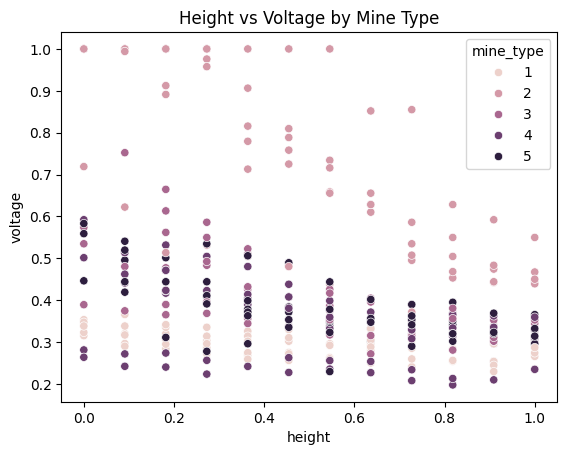

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(df, x="height", y="voltage", hue="mine_type")
plt.title("Height vs Voltage by Mine Type")
plt.show()

- Graph shows that mine type 2 has high voltage (always near 1) and very separated from the other types
- Mine type 1 has lower voltage and clustered together
- The other mine types are clustered together by height, many not reaching past 0.6 of voltage.

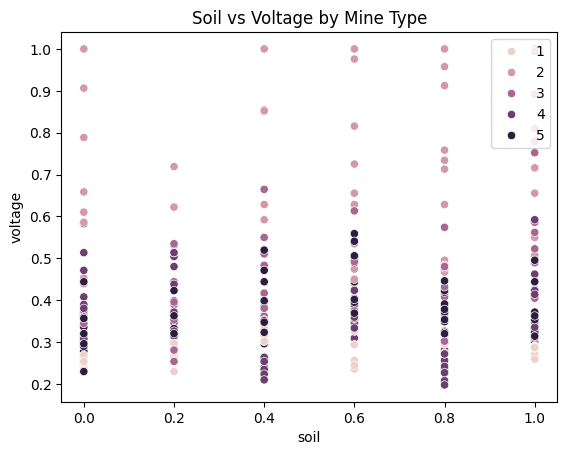

In [14]:
sns.scatterplot(df, x="soil", y="voltage", hue="mine_type")
plt.legend(loc="upper right")
plt.title("Soil vs Voltage by Mine Type")
plt.show()

- Again, mine type 2 has higher voltage across soil levels
- Soil alone does not separate classes

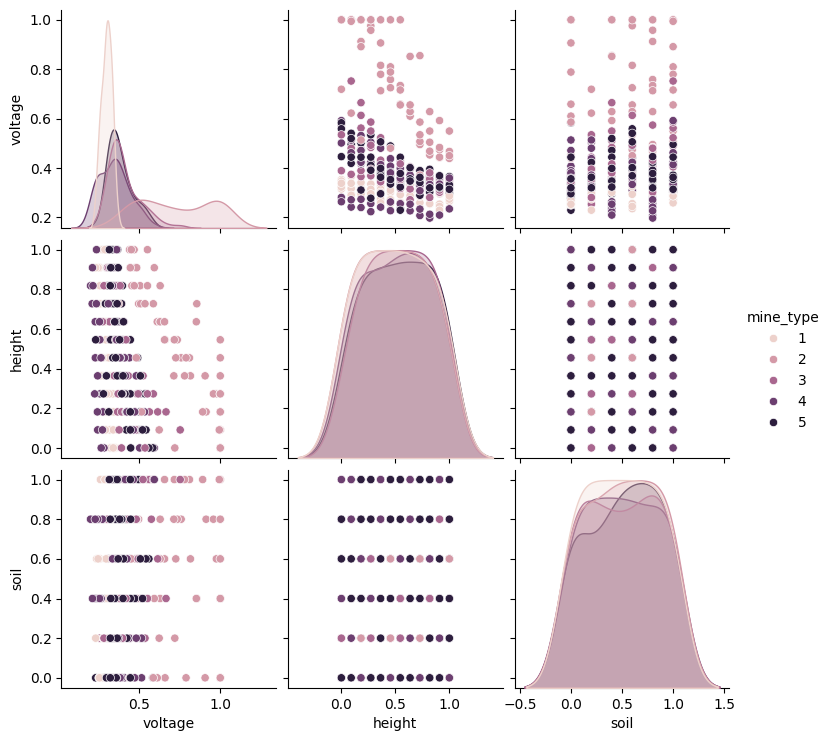

In [15]:
sns.pairplot(df, hue="mine_type")
plt.show()

- Strong separation in voltage
- In lower voltage, types 1 and 3 overlap a lot. 
- Height is pretty much uniformly distributed 
- Voltage decreases as height increases

In [16]:
df.corr()

,voltage,height,soil,mine_type
voltage,1.000000,-0.377523,0.070673,-0.144569
height,-0.377523,1.000000,-0.006957,0.041326
soil,0.070673,-0.006957,1.000000,0.017346
mine_type,-0.144569,0.041326,0.017346,1.000000


## Question 2: Part 2

In [17]:
# Separate features and target variable
X = df[['voltage', 'height', 'soil']]
y = df['mine_type']

In [18]:
# min-max scaling

def minmax(x):
    return (x - min(x)) / (max(x) - min(x))

X = X.apply(minmax)

In [ ]:
# 50/50 Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.5, # used 0.5 because my data is smaller 
    random_state = 100
)

## Question 2: Part 3

In [21]:
from sklearn.neighbors import KNeighborsClassifier

k = 5

model = KNeighborsClassifier(n_neighbors = k)
model = model.fit(X_train, y_train)
y_hat = model.predict(X_test) 
print(pd.crosstab(y_test, y_hat))
print("Test accuracy:", model.score(X_test, y_test))

col_0      1   2  3  4  5
mine_type                
1          7   0  3  0  3
2          0  11  2  1  0
3          2   0  4  6  2
4          6   1  6  1  2
5          2   0  6  3  0
Test accuracy: 0.3382352941176471


Test accuracy for 3 neighbors is 0.47058823529411764; train accuracy for 3 neighbors is 0.6777777777777778
Test accuracy for 5 neighbors is 0.3382352941176471; train accuracy for 5 neighbors is 0.6814814814814815
Test accuracy for 7 neighbors is 0.3088235294117647; train accuracy for 7 neighbors is 0.6148148148148148
Test accuracy for 9 neighbors is 0.29411764705882354; train accuracy for 9 neighbors is 0.5740740740740741
Test accuracy for 11 neighbors is 0.36764705882352944; train accuracy for 11 neighbors is 0.5703703703703704
Test accuracy for 13 neighbors is 0.3235294117647059; train accuracy for 13 neighbors is 0.562962962962963
Test accuracy for 15 neighbors is 0.3382352941176471; train accuracy for 15 neighbors is 0.5370370370370371
Test accuracy for 17 neighbors is 0.3235294117647059; train accuracy for 17 neighbors is 0.5296296296296297
Test accuracy for 19 neighbors is 0.3382352941176471; train accuracy for 19 neighbors is 0.5296296296296297
Test accuracy for 21 neighbors is 

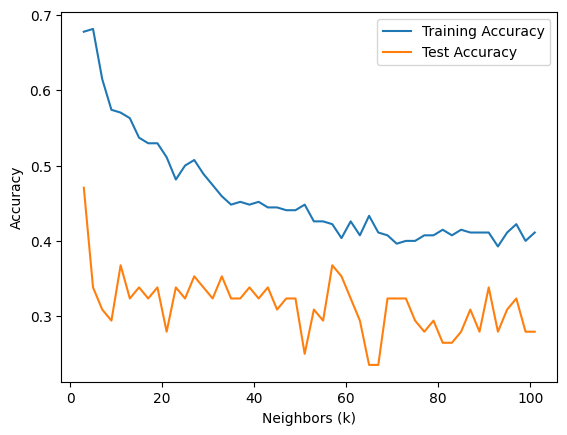

Optimal k values: [3]


In [24]:
# Candidate k values (odd numbers to reduce ties)
k_grid = np.array([(2*i + 1) for i in range(1, 51)])  # 3,5,...,101

test_accuracies = []
train_accuracies = []

for k in k_grid:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    test_acc = model.score(X_test, y_test)
    train_acc = model.score(X_train, y_train)
    print( f'Test accuracy for {k} neighbors is {test_acc}; train accuracy for {k} neighbors is {train_acc}')
    test_accuracies.append(test_acc)
    train_accuracies.append(train_acc)

# Plot train vs test accuracy across k
sns.lineplot(x=k_grid, y=train_accuracies, label="Training Accuracy").set(
    xlabel="Neighbors (k)", ylabel="Accuracy"
)
sns.lineplot(x=k_grid, y=test_accuracies, label="Test Accuracy")
plt.show()

# Pick k that maximizes test accuracy
is_optimal = test_accuracies == np.max(test_accuracies)
optimal_indices = np.where(is_optimal)
k_optimal = k_grid[optimal_indices]
print(f"Optimal k values: {k_optimal}")

I selected the k value by looping over a grid of candidate k values (using an odd k to reduce ties), fit the model on the training data, and computed the accuracy on both the training set and the test/validation set. Small k values tend to overfit (high training accuracy but worse test accuracy), while very large k values can underfit (both accuracies drop). I selected k by picking the k value that maximizes accuracy on the tes set, since this best reflects generalization to unseen data. The most optimal k I got was 3 (0.471)

## Question 2: Part 4

In [28]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_hat)
print(cm)

[[ 9  0  3  0  1]
 [ 0 10  4  0  0]
 [ 6  2  0  0  6]
 [12  0  4  0  0]
 [ 6  0  5  0  0]]


- As I computed earlier, accuracy is around 47%. 
- The most accurate classes are Class 1 and 2, with 9 and 10 correct. The rest having 0. The model is having trouble computing correct predictions for classes 3, 4, 5.

## Question 2: Part 5

In practice, I would not use this model as a final-decision maker since it can look good for some classes while making serious mistakes for the others. It correctly identifies many observations from certain mine types (high true positives), while misclassifying other types (high false negatives and false positives). In a land-mine setting, these mistakes are detrimental and could lead to the loss of lives with a false negative (failing to detect a dangerous mine) being far worse than a false positive (flagging something safe as a land-mine); therefore, I would use this model to flag risk, not to clear areas. I would also assume that the model is not dependable for the types of mines that it rarely predicts correctly (3, 4, or 5) and require additional information collection for those areas. I would add a human-in-the-loop or a secondary check for predictions that are higher-stakes.

**Q3.** This question is a case study for $k$ nearest neighbor regression, using the `USA_cars_datasets.csv` data.

The target variable `y` is `price` and the features are `year` and `mileage`.

1. Load the `./data/USA_cars_datasets.csv`. Keep the following variables and drop the rest: `price`, `year`, `mileage`. Are there any `NA`'s to handle? Look at the head and dimensions of the data.
2. Maxmin normalize `year` and `mileage`.
3. Split the sample into ~80% for training and ~20% for hyper-parameter selection and evaluation.
4. Use the $k$-NN algorithm and the training data to predict `price` using `year` and `mileage` for the test set for $k=3,10,25,50,100,300$. For each value of $k$, compute the mean squared error and print a scatterplot showing the test value plotted against the predicted value. What patterns do you notice as you increase $k$?
5. Determine the optimal $k$ for these data.
6. Describe what happened in the plots of predicted versus actual prices as $k$ varied, taking your answer into part 6 into account. (Hint: Use the words "underfitting" and "overfitting".)

## Question 3: Part 1

In [35]:
df = pd.read_csv("USA_cars_datasets.csv")

df.head()

,Unnamed: 0,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
0,0,6300,toyota,cruiser,2008,clean vehicle,274117,black,jtezu11f88k007763,159348797,new jersey,usa,10 days left
1,1,2899,ford,se,2011,clean vehicle,190552,silver,2fmdk3gc4bbb02217,166951262,tennessee,usa,6 days left
2,2,5350,dodge,mpv,2018,clean vehicle,39590,silver,3c4pdcgg5jt346413,167655728,georgia,usa,2 days left
3,3,25000,ford,door,2014,clean vehicle,64146,blue,1ftfw1et4efc23745,167753855,virginia,usa,22 hours left
4,4,27700,chevrolet,1500,2018,clean vehicle,6654,red,3gcpcrec2jg473991,167763266,florida,usa,22 hours left


In [37]:
df = df[["price", "mileage", "year"]]
df.head()

,price,mileage,year
0,6300,274117,2008
1,2899,190552,2011
2,5350,39590,2018
3,25000,64146,2014
4,27700,6654,2018


In [ ]:
df.isna().sum() # No NA's

price      0
mileage    0
year       0
dtype: int64

In [ ]:
df.shape # Correct dimensions

(2499, 3)

In [48]:
df.info()
df.describe()

<class 'pandas.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   price    2499 non-null   int64
 1   mileage  2499 non-null   int64
 2   year     2499 non-null   int64
dtypes: int64(3)
memory usage: 58.7 KB


,price,mileage,year
count,2499.000000,2.499000e+03,2499.000000
mean,18767.671469,5.229869e+04,2016.714286
std,12116.094936,5.970552e+04,3.442656
min,0.000000,0.000000e+00,1973.000000
25%,10200.000000,2.146650e+04,2016.000000
50%,16900.000000,3.536500e+04,2018.000000
75%,25555.500000,6.347250e+04,2019.000000
max,84900.000000,1.017936e+06,2020.000000


## Question 3: Part 2

In [49]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

#min-max scaling function
def minmax(x):
    u = (x-min(x)) / (max(x)-min(x))
    return u

# normalize year and mileage
df['year'] = minmax(df['year'])
df['mileage'] = minmax(df['mileage'])


## Question 3: Part 3

In [50]:
#train-test split
y = df['price']
ctrl_list = ['mileage', 'year']
X = df.loc[:, ctrl_list]

# test_size = 0.2 gives the 80/20 test/train split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=100)

## Question 3: Part 4

k = 3, MSE = 126426946.14


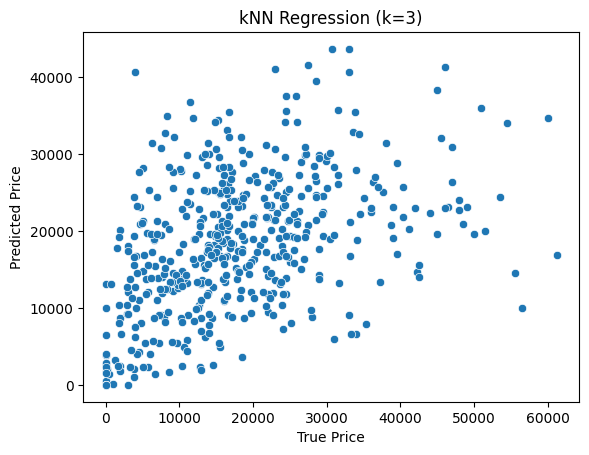

k = 10, MSE = 110706146.59


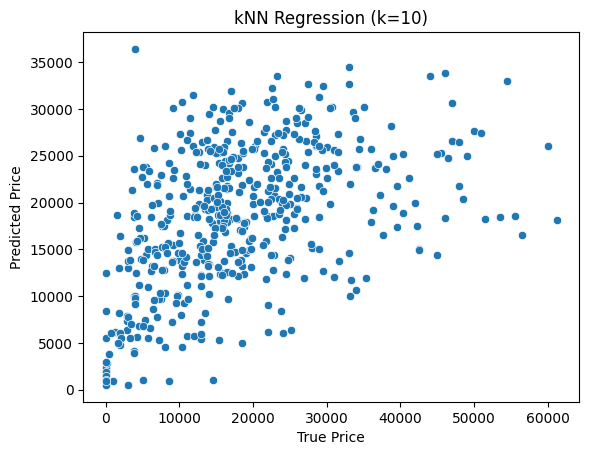

k = 25, MSE = 103167039.09


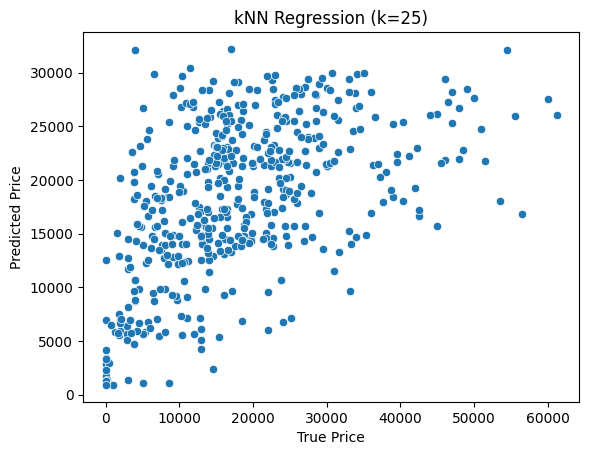

k = 50, MSE = 99773195.03


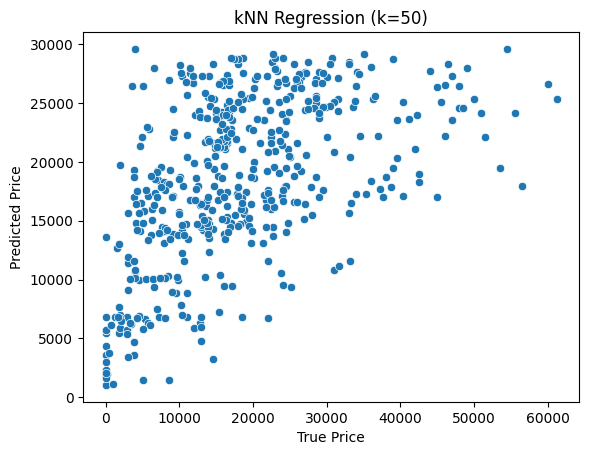

k = 100, MSE = 98276515.02


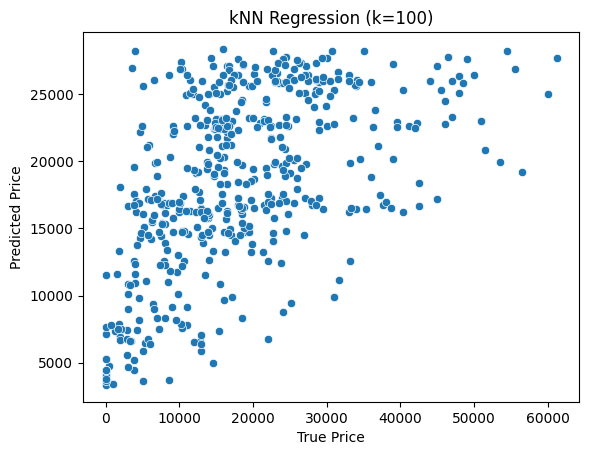

k = 300, MSE = 100477639.37


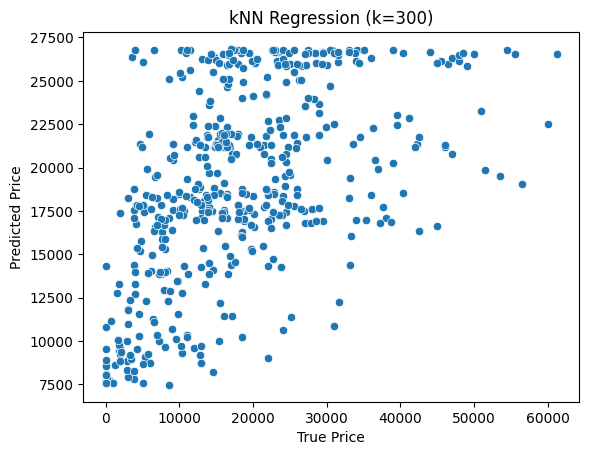

In [52]:
from sklearn.metrics import mean_squared_error

# fit kNN regression
k_values = [3, 10, 25, 50, 100, 300]

for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    
    y_hat = model.predict(X_test)

    mse = mean_squared_error(y_test, y_hat)
    print(f"k = {k}, MSE = {mse:.2f}")
    
    sns.scatterplot(x=y_test, y=y_hat)
    plt.xlabel("True Price")
    plt.ylabel("Predicted Price")
    plt.title(f"kNN Regression (k={k})")
    plt.show()

As you increase k, the diagonal alignment weakens, there is an increase in variance, and points start clustering more tightly (closer to the horizontal band for higher k). A larger k represents underfitted data (there are many predicted values near the mean price).

## Question 3: Part 5

k = 1, MSE = 198331920.09
k = 3, MSE = 126426946.14
k = 5, MSE = 116323295.56
k = 7, MSE = 112182591.50
k = 9, MSE = 110795640.79
k = 11, MSE = 110298429.52
k = 13, MSE = 108603693.78
k = 15, MSE = 106955918.74
k = 17, MSE = 105225675.80
k = 19, MSE = 105112915.58
k = 21, MSE = 104055535.88
k = 23, MSE = 103188254.21
k = 25, MSE = 103167039.09
k = 27, MSE = 102120000.88
k = 29, MSE = 101556852.18
k = 31, MSE = 102146424.39
k = 33, MSE = 101833881.42
k = 35, MSE = 101447118.91
k = 37, MSE = 101895684.67
k = 39, MSE = 101538202.64
k = 41, MSE = 100613702.37
k = 43, MSE = 99635297.23
k = 45, MSE = 99934801.84
k = 47, MSE = 99927831.17
k = 49, MSE = 99747207.68
k = 51, MSE = 99553164.03
k = 53, MSE = 99286537.91
k = 55, MSE = 99388242.77
k = 57, MSE = 99388580.97
k = 59, MSE = 99342609.59
k = 61, MSE = 99100446.98
k = 63, MSE = 99025546.57
k = 65, MSE = 99075208.84
k = 67, MSE = 99048222.48
k = 69, MSE = 98876855.92
k = 71, MSE = 98540223.92
k = 73, MSE = 98115904.81
k = 75, MSE = 98057904

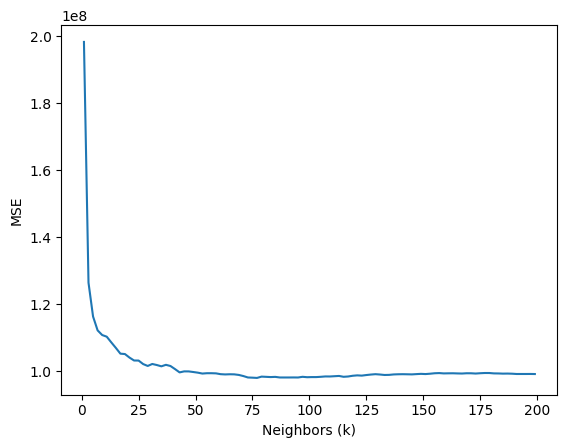

In [56]:
# picking optimal k
k_grid = [ (2*k+1) for k in range(100)]
mses = []
for k in k_grid:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    mse = mean_squared_error(y_test, y_hat)
    mses.append(mse)
    print(f"k = {k}, MSE = {mse:.2f}")
sns.lineplot(x=k_grid, y=mses).set(ylabel="MSE", xlabel="Neighbors (k)")

#finds lowest value that MSE takes over all k
index_stars = np.argmin(mses)
k_star = k_grid[index_stars]
print(f"Optimal k: {k_star}, with MSE: {mses[index_stars]:.2f}")

Optimal k is 77

## Question 3: Part 6

As k increased, the predicted vs. actual scatterplots reflected the bias-variance tradeoff. For small values of k, the model overfit the data (predictions were noisy and highly variable with low bias and high variance). As k became larger, the model underfit (predictions collapsed toward the overall mean price, which did not catch a meaningful structure). An intermediate value of k minimized test MSE and provided the best balance between underfitting and overfitting.

**Q4.** This question is a case study for $k$ nearest neighbor regression, using the `heart_failure_clinical_records_dataset.csv` data.

The data for the question include:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- death event: if the patient deceased during the follow-up period (boolean)

1. Load the `./data/heart_failure_clinical_records_dataset.csv`. Are there any `NA`'s to handle? use `.drop()` to remove `time` from the dataframe.
2. Make a correlation matrix. What variables are strongly associated with a death event?
3. For the dummy variables `anaemia`, `diabetes`, `high_blood_pressure`, `sex`, and `smoking`, compute a summary table of `DEATH_EVENT` grouped by the variable. For which variables does a higher proportion of the population die when the variable takes the value 1 rather than 0?
4. On the basis of your answers from 2 and 3, build a matrix $X$ of the variables you think are most predictive of a death, and a variable $y$ equal to `DEATH_EVENT`.
5. Maxmin normalize all of the variables in `X`.
6. Split the sample into ~80% for training and ~20% for evaluation. (Try to use the same train/test split for the whole question, so that you're comparing apples to apples in the questions below.).
7. Determine the optimal number of neighbors for a $k$-NN classification or regression for the variables you selected.
8. OK, do steps 5 through 7 again, but use all of the variables (except `time`). Which model has the best Mean Squared Error? Which would you prefer to use in practice, if you had to predict `DEATH_EVENT`s? If you play with the selection of variables, how much does the RMSE change for your fitted model on the test data? Are more variables always better? Explain your findings.

**Q5.** This is a case study on $k$ nearest neighbor classification, using the `animals.csv` data.

The data consist of a label, `class`, taking integer values 1 to 7, the name of the species, `animal`, and 16 characteristics of the animal, including `hair`, `feathers`, `milk`, `eggs`, `airborne`, and so on. 

1. Load the data. For each of the seven class labels, print the values in the class and get a sense of what is included in that group. Perform some other EDA: How big are the classes? How much variation is there in each of the features/covariates? Which variables do you think will best predict which class?
2. Split the data 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be. Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)
3. Using all of the variables, build a $k$-NN classifier. Explain how you select $k$.
4. Print a confusion matrix for the optimal model, comparing predicted and actual class label on the test set. How accurate it is? Can you interpret why mistakes are made across groups?
5. Use only `milk`, `aquatic`, and `airborne` to train a new $k$-NN classifier. Print your confusion table. Mine does not predict all of the classes, only a subset of them. To see the underlying proportions/probabilities, use `model.predict_proba(X_test.values)` to predict probabilities rather than labels for your `X_test` test data for your fitted `model`. Are all of the classes represented? Explain your results.

**Q6.** This is a case study using $k$ nearest neighbor regression for imputation, using the `airbnb_hw.csv` data.

There are 30,478 observations, but only 22,155 ratings. We're going to build a kNN regressor to impute missing values. This is a common task, and illustrates one way you can use kNN in the future even when you have more advanced models available.

1. Load the `airbnb_hw.csv` data with Pandas. We're only going to use `Review Scores Rating`, `Price`, and `Beds`, so use `.loc` to column filter the dataframe to those variables.
2. Set use `.isnull()` and `.loc` to select the subset of the dataframe with missing review values. Set those aside in a different dataframe. We'll make predictions about them later.
3. Use `df = df.dropna(axis = 0, how = 'any')` to eliminate any observations with missing values/NA's from the dataframe.
4. For the complete cases, create a $k$-NN model that uses the variables `Price` and `Beds` to predict `Review Scores Rating`. How do you choose $k$? (Hint: Train/test split, iterate over reasonable values of $k$ and find a value that minimizes SSE on the test split using predictions from the training set.)
5. Predict the missing ratings. 
6. Do a kernel density plot of the training ratings and the predicted missing ratings. Do they look similar or not? Describe what you see.

## Question 6: Part 1

In [114]:
df = pd.read_csv("airbnb_hw.csv")
df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [115]:
df = df.loc[:, ["Review Scores Rating", "Price", "Beds"]]
df.head()

,Review Scores Rating,Price,Beds
0,NaN,145,1.0
1,NaN,37,1.0
2,NaN,28,1.0
3,NaN,199,3.0
4,96.0,549,3.0


## Question 6: Part 2

In [116]:
# New dataset for missing values
df_missing = df.loc[df["Review Scores Rating"].isnull(), :]
df_missing.head()

,Review Scores Rating,Price,Beds
0,NaN,145,1.0
1,NaN,37,1.0
2,NaN,28,1.0
3,NaN,199,3.0
13,NaN,68,1.0


## Question 6: Part 3

In [101]:
df = df.dropna(axis = 0, how = 'any')
df.head()

,Review Scores Rating,Price,Beds
4,96.0,549,3.0
5,100.0,149,1.0
6,100.0,250,1.0
7,94.0,90,1.0
8,90.0,270,2.0


## Question 6: Part 4

In [105]:
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df["Beds"] = pd.to_numeric(df["Beds"], errors="coerce")
df_complete = df.dropna(subset=["Review Scores Rating", "Price", "Beds"])
df.dtypes

Review Scores Rating    float64
Price                   float64
Beds                    float64
dtype: object

In [106]:
X = df_complete[["Price", "Beds"]]
y = df_complete["Review Scores Rating"]

#min-max scaling
def minmax(x):
    u = (x-min(x))/(max(x)-min(x))
    return u

# normalize 
y = df_complete['Review Scores Rating']
ctrl_list = ["Price", "Beds"]
x = df_complete.loc[:, ctrl_list]
u = x.apply(minmax)

u_train, u_test, y_train, y_test = train_test_split(u,y,test_size=0.2, random_state=100)

In [123]:
# iterate over k and computer SSE

k_grid = [(2*k + 1) for k in range(100)]
sses = []

for k in k_grid:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(u_train, y_train)  
    
    y_hat = model.predict(u_test) 
    
    sse = np.sum((y_test - y_hat)**2)
    sses.append(sse)

index_star = np.argmin(sses)
k_star = k_grid[index_star]

print(f"Optimal k: {k_star}, with SSE: {sses[index_star]:.2f}")

Optimal k: 197, with SSE: 354656.05


## Question 6: Part 5

In [108]:
# predictors and target from complete cases
X_full = df_complete[["Price", "Beds"]]
y_full = df_complete["Review Scores Rating"]

# apply the same scaling as before
X_full = (X_full - X_full.min()) / (X_full.max() - X_full.min())

# fit final model
final_model = KNeighborsRegressor(n_neighbors=k_star)
final_model.fit(X_full, y_full)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",197
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Uniform weights are used by default.See the following example for a demonstration of the impact ofdifferent weighting schemes on predictions::ref:`sphx_glr_auto_examples_neighbors_plot_regression.py`.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this isequivalent to using manhattan_distance (l1), and euclidean_distance(l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.",2
,"metric metric: str, DistanceMetric object or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.If metric is a DistanceMetric object, it will be passed directly tothe underlying computation routines.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [119]:
df_missing = df.loc[df["Review Scores Rating"].isnull(), ["Price", "Beds"]].copy()

df_missing["Price"] = pd.to_numeric(df_missing["Price"], errors="coerce")
df_missing["Beds"]  = pd.to_numeric(df_missing["Beds"], errors="coerce")

df_missing = df_missing.dropna()

# scale df_missing
df_missing_scaled = (df_missing - X_full.min()) / (X_full.max() - X_full.min())

predicted_ratings = final_model.predict(df_missing_scaled)
df_missing["Predicted Review Scores Rating"] = predicted_ratings
df_missing.head()

,Price,Beds,Predicted Review Scores Rating
0,145.0,1.0,94.208122
1,37.0,1.0,94.208122
2,28.0,1.0,94.208122
3,199.0,3.0,94.208122
13,68.0,1.0,94.208122


I predicted the same review scores rating for all of the variables. This suggests that review scores have a limited variation and that price and beds may not provide high discriminatory power. 

## Question 6: Part 6

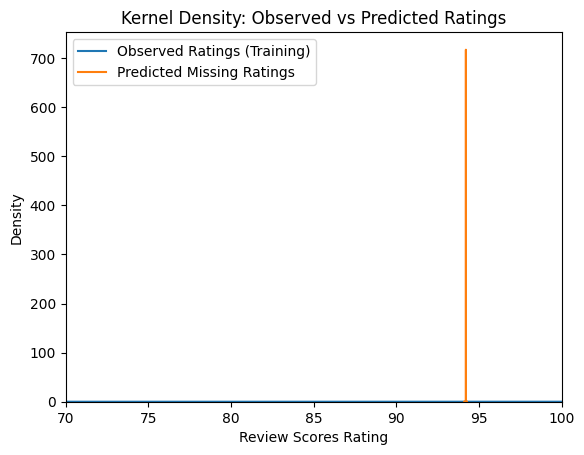

In [121]:
#kde plot of observed vs predicted ratings
plt.xlim(70, 100)
sns.kdeplot(y_full, label="Observed Ratings (Training)")
sns.kdeplot(predicted_ratings, label="Predicted Missing Ratings")

plt.xlabel("Review Scores Rating")
plt.ylabel("Density")
plt.legend()
plt.title("Kernel Density: Observed vs Predicted Ratings")
plt.show()

The blue line shows the real distribution of review scores (70-100), while the orange spike  (predicted missing ratings) is centered around the average review score. I'm not sure if I did this correctly...but if I did this shows that price and beds do not strongly explain the variation in ratings (the model is underfitting). 

**Q7.** Let's do some very basic computer vision. We're going to import the MNIST handwritten digits data and use $k$-NN to predict values (i.e. "see/read").

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5): 
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a list of matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use the reshaped `X_test` and `y_test` data to create a $k$-nearest neighbor classifier of digit. What is the optimal number of neighbors $k$? If you can't determine this, play around with different values of $k$ for your classifier.
5. For the optimal number of neighbors, how well does your predictor perform on the test set? Report the accuracy, compute a confusion matrix, and explain your findings.
6. For your confusion matrix, which mistakes are most likely? Do you find any interesting patterns?
7. So, this is how computers "see." They convert an image into a matrix of values, that matrix becomes a vector in a dataset, and then we deploy ML tools on it as if it was any other kind of tabular data. To make sure you follow this, invent a way to represent a color photo in matrix form, and then describe how you could convert it into tabular data. (Hint: RGB color codes provide a method of encoding a numeric value that represents a color.)